In [1]:
%cd '/content/drive/MyDrive/Colab Notebooks/Data'

/content/drive/MyDrive/Colab Notebooks/Data


In [2]:
!ls

covid19-ct-scans  Pickle_Data.csv  Processed_Data.cp


In [29]:
import pandas as pd
import pickle
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import os as os
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm.notebook as tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras import callbacks
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

#### First select the GPU option from the Hardware Accelerator provided by Google Colab. we can confirm that we are [connected to the GPU](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=tMce8muBqXQP) with tensorflow:

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Loading the preprocessed data we have saved earlier.

In [5]:
pickle_file = open("Processed_Data.cp", "rb")
objects = []
while True:
    try:
        dictionary = pickle.load(pickle_file)
        all_cts = dictionary['cts']
        all_lungs =dictionary['lungs']
    except EOFError:
        break
pickle_file.close()

print(objects)

[]


In [6]:
print('Total number of slides of CTscan: {}, Shape of each slide: {}'.format(all_cts.shape[0],all_cts[213].shape))
print('Total number of slides of Lung infection masks: {}, Shape of each slide: {}'.format(all_lungs.shape[0],all_cts[1172].shape))

Total number of slides of CTscan: 1564, Shape of each slide: (128, 128, 1)
Total number of slides of Lung infection masks: 1564, Shape of each slide: (128, 128, 1)


In [7]:
from sklearn.utils import shuffle
all_cts, all_lungs = shuffle(all_cts, all_lungs) #synchronized shuffling of data

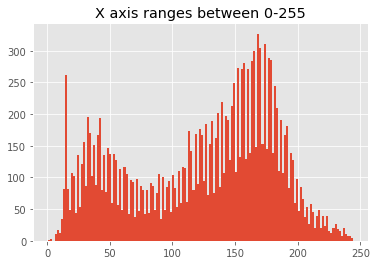

In [8]:
with plt.style.context('ggplot'):
    plt.hist(all_cts[10].flatten(),bins=150)
    plt.title('X axis ranges between 0-255')

#### The pixel values for ct-scan slides ranges between 0-255 and 0-2 for lung masks ,we can normalize them for better results and fast processing

In [9]:
all_cts = (all_cts - all_cts.min())/(all_cts.max()-all_cts.min())
all_lungs = (all_lungs - all_lungs.min())/(all_lungs.max()-all_lungs.min())
print("{} {}".format(all_cts.min(), all_cts.max()))
print("{} {}".format(all_lungs.min(), all_lungs.max()))

0.0 1.0
0.0 1.0


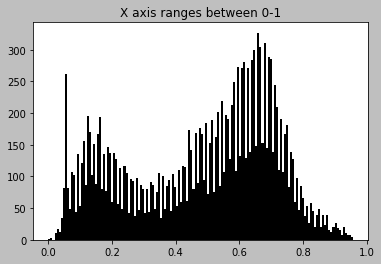

In [10]:
with plt.style.context('grayscale'):
    plt.hist(all_cts[10].flatten(),bins=150)
    plt.title('X axis ranges between 0-1')

#### We will split the dataset into training data ( 80% ), testing data( 10% ) and validation data( 10% ).

In [11]:
X_train = all_cts[:round(len(all_cts)*0.8)]
Y_train = all_lungs[:round(len(all_lungs)*0.8)]

X_val = all_cts[round(len(all_cts)*0.8):round(len(all_cts)*0.9)]
Y_val = all_lungs[round(len(all_lungs)*0.8):round(len(all_lungs)*0.9)]

X_test = all_cts[round(len(all_cts)*0.9):]
Y_test = all_lungs[round(len(all_lungs)*0.9):]

print("{} {}".format(X_train.shape, Y_train.shape))
print("{} {}".format(X_val.shape, Y_val.shape))
print("{} {}".format(X_test.shape, Y_test.shape))

(1251, 128, 128, 1) (1251, 128, 128, 1)
(157, 128, 128, 1) (157, 128, 128, 1)
(156, 128, 128, 1) (156, 128, 128, 1)


### Defining Loss and Accuracy functiton

In [13]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [14]:
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [15]:
im_width = 128
im_height = 128

In [16]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  """Function to add 2 convolutional layers with the parameters passed to it"""
  # first layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)
    
    # second layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)
    
  return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  # Contracting Path
  c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)
    
  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)
    
  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
  
  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  
  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  
  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  
  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [17]:

initial_learning_rate = 0.0001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss=dice_coef_loss,
    metrics=[dice_coef]
)
# checkpoint_cb = callbacks.ModelCheckpoint(
#     "3d_image_segmentation.h5", save_best_only=True
# )
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('3d_image_segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [18]:
history = model.fit(X_train, Y_train, batch_size=32, epochs = 50, validation_data = (X_val, Y_val), callbacks = callbacks,  shuffle=True)

Epoch 1/50
40/40 [==============================] - 37s 116ms/step - loss: -0.3225 - dice_coef: 0.3226 - val_loss: -0.3677 - val_dice_coef: 0.3676

Epoch 00001: val_loss improved from inf to -0.36765, saving model to 3d_image_segmentation.h5
Epoch 2/50
40/40 [==============================] - 3s 85ms/step - loss: -0.5689 - dice_coef: 0.5690 - val_loss: -0.4968 - val_dice_coef: 0.4968

Epoch 00002: val_loss improved from -0.36765 to -0.49677, saving model to 3d_image_segmentation.h5
Epoch 3/50
40/40 [==============================] - 3s 84ms/step - loss: -0.6443 - dice_coef: 0.6444 - val_loss: -0.4059 - val_dice_coef: 0.4059

Epoch 00003: val_loss did not improve from -0.49677
Epoch 4/50
40/40 [==============================] - 3s 84ms/step - loss: -0.6727 - dice_coef: 0.6727 - val_loss: -0.3652 - val_dice_coef: 0.3652

Epoch 00004: val_loss did not improve from -0.49677
Epoch 5/50
40/40 [==============================] - 3s 85ms/step - loss: -0.6895 - dice_coef: 0.6895 - val_loss: -0.4

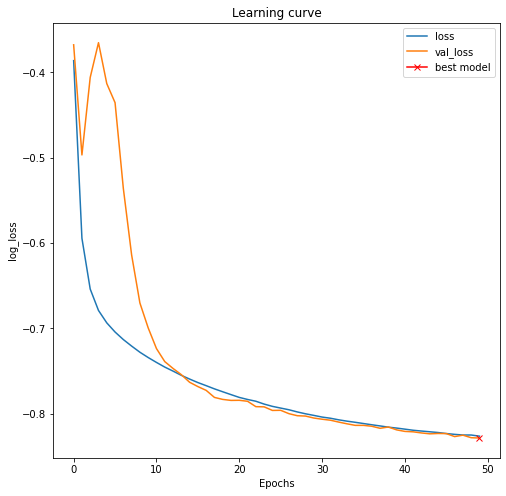

In [19]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [20]:
# load the best model
model.load_weights('3d_image_segmentation.h5')

In [21]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_val, Y_val, verbose=1)

5/5 [==============================] - 0s 26ms/step - loss: -0.8287 - dice_coef: 0.8285


[-0.8286980986595154, 0.828515887260437]

In [22]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
prediction = model.predict(X_test)

5/5 [==============================] - 0s 27ms/step


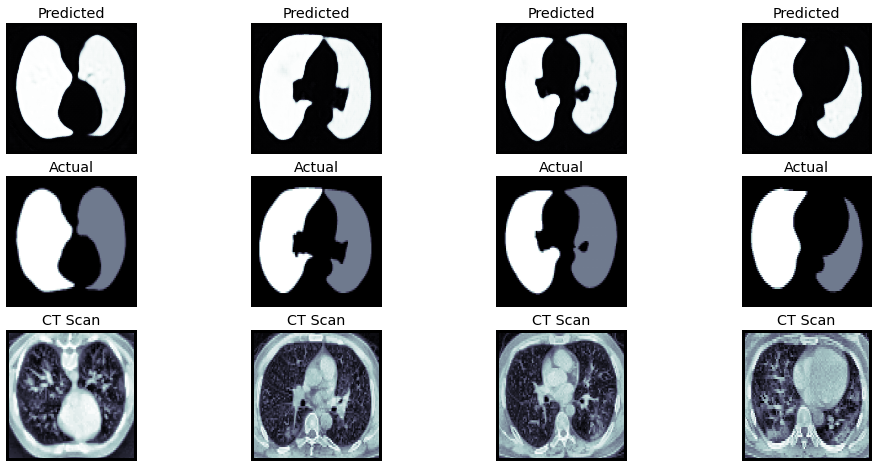

In [30]:
import random
fig, axes = plt.subplots(3, 4, figsize=(15,8))

for i in range(4):
    c = random.randint(0,prediction.shape[0]-1)
    axes[0,i].imshow(np.squeeze(prediction[c]),cmap='bone')
    axes[0,i].set_title('Predicted')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1,i].imshow(np.squeeze(Y_test[c]),cmap='bone')
    axes[1,i].set_title('Actual')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([]) 

    axes[2,i].imshow(np.squeeze(X_test[c]),cmap='bone')
    axes[2,i].set_title('CT Scan')
    axes[2,i].set_xticks([])
    axes[2,i].set_yticks([])    